# Wordle Solver

### Data: https://www.kaggle.com/datasets/bcruise/wordle-valid-words

In [7]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
from tqdm import tqdm

np.random.seed(42)
random.seed(42)

df_solutions = pd.read_csv('valid_solutions.csv')

word_list = df_solutions['word'].tolist()
random.shuffle(word_list)

In [16]:
def print_stats(data):
    df = pd.DataFrame(data, columns=['guesses_num'])
    print(df.describe()[1:])
    
def show_dist(arrays, names, log_x=False, log_y=False, x_range=None, hist=False):
    df_compare = pd.DataFrame(
        np.array(
            arrays,
            dtype=np.int32
        ).T,
        columns=[*names]
    )

    if hist:
        sns.histplot(df_compare, bins=100, palette='rocket')
    else:
        sns.displot(df_compare, kind='kde', fill=True, palette='rocket')
    plt.xlabel('Number of guesses')
    if log_x:
        plt.xscale('log')
    if log_y:
        plt.yscale('log')
    if x_range:
        plt.xlim(x_range)
    plt.title('Number of guesses distribution')
    plt.show()

# Algorithm Validator

In [31]:
class Algorithm:
    def __init__(self, word_list):
        self.word_list = word_list

    @staticmethod
    def validate_ans(ans: str, word: str):
        output = [0 for _ in range(len(word))]
        new_ans = ''
        new_word = ''
        new_idx = []
        
        for i in range(len(word)):
            if ans[i] == word[i]:
                output[i] = 2
            else:
                new_ans += ans[i]
                new_word += word[i]
                new_idx.append(i)
                
        for i in range(len(new_ans)):
            if new_ans[i] in new_word and new_ans[:i].count(new_ans[i]) < new_word.count(new_ans[i]):
                output[new_idx[i]] = 1
            else:
                output[new_idx[i]] = 0
        
        return output
    
    def validate_algorithm(self, show_loop: bool=True, **kwargs):
        guesses_stats = []
        word_list = self.word_list
        
        for word in tqdm(
            word_list,
            desc='Validating algorithm',
            total=len(word_list),
            bar_format='{l_bar}{bar:20}{r_bar}{bar:-20b}',
            unit=' guessed words'
            ) if show_loop else word_list:
            
            guesses_num = 0
            answer_list, answer_info = [], []
            possible_words = deepcopy(word_list)
            
            while True:
                guess, possible_words = self.f(
                    answer_list, 
                    answer_info, 
                    possible_words=possible_words, 
                    **kwargs
                    )
                answer_list.append(guess)
                answer_info.append(Algorithm.validate_ans(guess, word))
                guesses_num += 1
                if guess == word:
                    guesses_stats.append(guesses_num)
                    break
                
        return guesses_stats

    def f(self, ans, ans_info, possible_words, **kwargs): ...


In [32]:
assert Algorithm.validate_ans('aabaa', 'ababa') == [2, 1, 1, 0, 2]
assert Algorithm.validate_ans('aabad', 'ababa') == [2, 1, 1, 1, 0]
assert Algorithm.validate_ans('ababa', 'ababa') == [2, 2, 2, 2, 2]
assert Algorithm.validate_ans('ababa', 'babab') == [1, 1, 1, 1, 0]
assert Algorithm.validate_ans('bbbbb', 'aaaaa') == [0, 0, 0, 0, 0]

## Random Algorithm with Answer Recudction

In [37]:
class RAAR(Algorithm):
    def f(self, ans, ans_info, possible_words, **kwargs):
        if len(ans) > 0:
            possible_words = [
                word for word in possible_words 
                if Algorithm.validate_ans(word, ans[-1]) == ans_info[-1]
            ]
        return np.random.choice(possible_words), possible_words

In [38]:
rawci_stats = np.array(RAAR(word_list).validate_algorithm()).T

Validating algorithm:   0%|                    | 0/2315 [00:00<?, ? guessed words/s]

2315
4
0


ValueError: 'a' cannot be empty unless no samples are taken

In [13]:
print_stats(rawci_stats)

      guesses_num      time
mean     5.719654  0.002588
std      2.885083  0.001628
min      1.000000  0.000134
25%      4.000000  0.001520
50%      5.000000  0.002250
75%      7.000000  0.003225
max     40.000000  0.021033


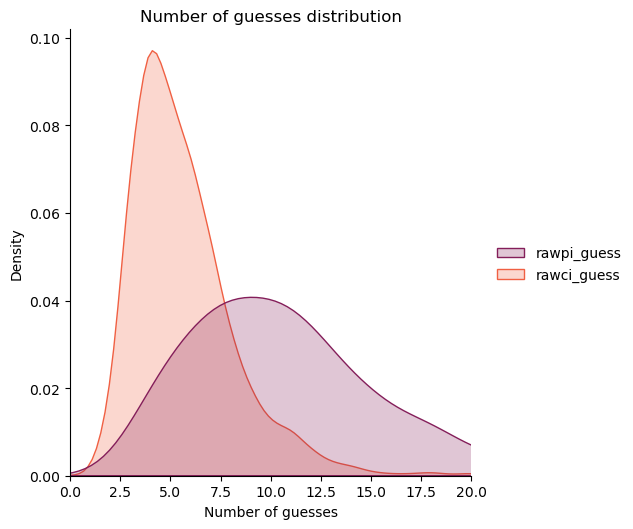

In [14]:
show_dist(
    arrays=[rawpi_stats[:, 0], rawci_stats[:, 0]],
    names=['rawpi_guess', 'rawci_guess'],
    x_range=(0, 20)
)